# **Titanic: Machine Learning from Disaster - Part 4** #

In [1]:
import pandas as pd
%matplotlib inline

# load the already explored datasets
train = pd.read_csv('dataset/train_explored.csv')
test = pd.read_csv('dataset/test_explored.csv')

train.head()

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Family,Sex_female,Sex_male
0,0,22.0,7.2500,0,0,1,1,0,1
1,1,38.0,71.2833,1,0,0,1,1,0
2,1,26.0,7.9250,0,0,1,0,1,0
3,1,35.0,53.1000,1,0,0,1,1,0
4,0,35.0,8.0500,0,0,1,0,0,1


## **5. Machine Learning** ##

In this section, we build a predictive model based on machine learning algorithms so that we can predict the chance of surviving for unseen data. First, we need to do some preprocessing steps. A very popular preprocessing approach before modeling is normalization (except for some algorithms like Decision Tree). Let's do it.

In [2]:
from sklearn.preprocessing import StandardScaler

# split into X(our features) and Y(our output)
X_train = train.drop("Survived", axis =1)
Y_train = train['Survived']
X_test = test

# normalization the data
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)

# notice that it is "transform", not "fit_transform"
X_test = X_scaler.transform(X_test)

Next, we will spot-check some machine learning models. The Titanic competition is a binary classification problem. Here are the models and their core ideas:
- Logistic regression: the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.
- K-nearest neighbor: an instance's output is equal to the most voted labels of its k nearest neighbors.
- Support vector machine: construct a seperation hyperplane that has the largest distance to the nearest training-data point of any class.
- Majority voting: an ensemble model where we combine different machine learning classifiers (here are the previous 3!) and use a majority vote (hard) or the average predicted probabilities (soft) to predict the class labels.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# list of models
models = []

# logistic regression
cl1 = LogisticRegression(n_jobs = -1)
models.append(('LR', cl1))

# k-nearest neighbors
cl2 = KNeighborsClassifier(n_jobs = -1)
models.append(('KNN', cl2))

# support vector machine
cl3 = SVC(probability = True, cache_size = 1000)
models.append(('SVM', cl3))

# majority voting
mv_cl = VotingClassifier(estimators=[('LR', cl1), ('KNN', cl2),
                                    ('SVM', cl3)],
                                    voting='soft', n_jobs = -1)
models.append(('EN', mv_cl))

We will compare the 4 different approach by their cross-validation scores on the train data, then visualize them on boxplots.

In [4]:
from helpers.compare_algorithms_helper import evaluate_models

# compute the mean and standard deviation of CV scores
results, names = evaluate_models(models, X_train, Y_train)

LR: 0.791261 +/- 0.020664
KNN: 0.811548 +/- 0.047019
SVM: 0.819313 +/- 0.031499
EN: 0.823820 +/- 0.029561


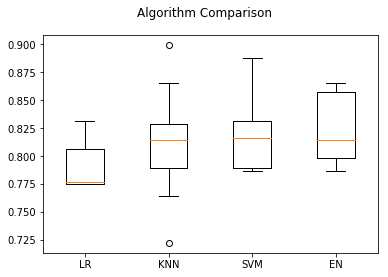

In [5]:
from helpers.compare_algorithms_helper import boxplot_algorithm_comparison

# visualize the CV scores
boxplot_algorithm_comparison(results, names)

After spot-check the default implementation of machine learning algorithms on scikit-learn, the ensemble model (voting classifier) seems to produce the best result with high mean and low standard deviation (cross-validation scores). It will be our model of choice. Next, we will tune the selected model to improve its performance.

In [6]:
model = mv_cl
model.get_params()

{'KNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
            weights='uniform'),
 'KNN__algorithm': 'auto',
 'KNN__leaf_size': 30,
 'KNN__metric': 'minkowski',
 'KNN__metric_params': None,
 'KNN__n_jobs': -1,
 'KNN__n_neighbors': 5,
 'KNN__p': 2,
 'KNN__weights': 'uniform',
 'LR': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'LR__C': 1.0,
 'LR__class_weight': None,
 'LR__dual': False,
 'LR__fit_intercept': True,
 'LR__intercept_scaling': 1,
 'LR__max_iter': 100,
 'LR__multi_class': 'ovr',
 'LR__n_jobs': -1,
 'LR__penalty': 'l2',
 'LR__random_state': None,
 'LR__solver': 'liblinear',
 'LR__tol': 0.0001,
 'LR__verbose': 0,
 'LR__warm_start': False,
 'SVM': SVC(C=1.0, cache

We will use nested cross-validation. In the inner loop, we will use a grid search exhaustive approach to find the best hyperparameters for the individual models in our ensemble model. Then in the outer loop, we will validate our model on the whole train data.

In [7]:
from sklearn.model_selection import GridSearchCV, cross_val_score

# Set up possible values of parameters to optimize over
p_grid = {'KNN__n_neighbors': [5, 10, 15],
                 'LR__C': [0.1, 1.0, 10.0],
                  'SVM__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                 'SVM__C': [0.1, 1.0, 10.0],
                }

# inner loop of cross-validation
grid = GridSearchCV(estimator = model, param_grid=p_grid, cv = 5, n_jobs = -1)

# outer loop of cross-validation
cross_val_score(grid, X = X_train, y = Y_train, cv = 3, n_jobs = -1)

array([ 0.80808081,  0.82828283,  0.81818182])

We will "retrain" our model using the new optimized hyperparameters, then use the model to predict the result on the test set.

In [8]:
# retrain the model
grid.fit(X_train, Y_train)

# predict on test set
Y_pred = grid.predict(X_test)

## **6. Deployment.** ##

Finally, we will deploy our result, which is creating a .csv file to store our prediction. 

In [9]:
test_df = pd.read_csv('dataset/test.csv')
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('outputs/titanic.csv', index=False)

Now we are ready to submit our solution to Kaggle!